## Evaluation of wind source in Finland by using ERA5 wind speed data in terms of suitable fractions of a year to run household appliances within specified waiting tolerances.
- **FMI**: 200+ FMI stations, observation data.
- **ERA5**: Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset from January 1940 to present. The spatial resolution is 0.25*0.25 degree, and temporal resolution is 1 hour. 
- **NEWA**(New European Wind Atlas):  This dataset covers the entire EU plus Turkey and 100 km offshore as well as the complete North and Baltic Seas, with a 3 km grid spacing and 30 mins temporal resolution, and a coverage of 30 years (1989-2018). 

In [1]:
from mpl_toolkits.basemap import Basemap  # import Basemap matplotlib toolkit
import netCDF4 as nc  ## Library to read netCDF4 data 
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [4]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pickle
import json

## Wind Turbines and Wind to Power Transformation Methods

In [5]:
# %load config.py
from windpowerlib import WindTurbine
import pandas as pd

# specification of own wind turbine (Note: power curve values and
# nominal power have to be in Watt)  
# Backyard turbine: Automaxx Windmill 1500W 48V 60A Home Wind Turbine
my_turbine = {
    'nominal_power': 3e6,  # in W
    'hub_height': 10,  # in m
    'power_curve': pd.DataFrame(
        data={'value': [
            0.0, 40.0, 60.0, 105.1, 400.0, 600.0, 900.0,1500.0],  # in W
            'wind_speed': [0.0, 3.0, 4.5, 5.0, 6.5, 7.5, 10, 14]})  # in m/s
}
# initialize WindTurbine object
my_turbine = WindTurbine(**my_turbine)

# Camping turbine
rutland504 = {
    'nominal_power': 3e6,  # in W
    'hub_height': 10,  # in m
    'power_curve': pd.DataFrame(
        data={'value': [
            0.0, 0.0, 3.0, 11.1, 29.0, 39.0],  # in W
            'wind_speed': [0.0, 3.0, 5.1, 7.0, 11.0, 13.0]})  # in m/s
}
# initialize WindTurbine object
rutland504 = WindTurbine(**rutland504)


n100 = {
    'hub_height': 100,
    'turbine_type': 'N100/2500'}
n100 = WindTurbine(**n100)


e48 = {
    'hub_height': 100,
    'turbine_type': 'E48/800'}
e48 = WindTurbine(**e48)


In [6]:
# %load wind_power_transformation.py
import pandas as pd
import numpy as np

from windpowerlib import ModelChain, WindTurbine, create_power_curve, wind_speed

def hellman(
    wind_speed,
    wind_speed_height,
    hub_height,
    roughness_length=None,
    hellman_exponent=None
):
    hellman_exponent = 1 / 7
    return wind_speed * (hub_height / wind_speed_height) ** hellman_exponent


wind_speed.hellman = hellman


def speed_to_power(weather_df, my_turbine):

    mc_my_turbine = ModelChain(
        my_turbine,
        power_output_model='power_curve',
        wind_speed_model='hellman')
    mc_my_turbine.run_model(weather_df)
    # write power output time series to WindTurbine object
    my_turbine.power_output = mc_my_turbine.power_output.values
    return my_turbine.power_output

## Loading ERA5 data (2022)

In [7]:
# #ERA5 hourly wind speed at 100m of 2021
# fn = 'adaptor.mars.internal-1675753156.1999435-7330-11-dc7a0246-a189-4243-add8-30e554ed80c6.nc'

#ERA5 hourly wind speed at 10m of 2022; time points: 00:00,01:00,......,23:
fn = "ERA5_hourly_2021.nc"
ds = nc.Dataset(fn)

In [8]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-08-04 12:31:06 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data8/adaptor.mars.internal-1691152201.67452-21246-3-510c14ef-b360-4e9b-a814-0b3f932ff1dc.nc /cache/tmp/510c14ef-b360-4e9b-a814-0b3f932ff1dc-adaptor.mars.internal-1691151578.3637197-21246-7-tmp.grib
    dimensions(sizes): longitude(65), latitude(61), time(8760)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 u10(time, latitude, longitude), int16 v10(time, latitude, longitude)
    groups: 


In [9]:
lats = ds['latitude'][:]
lons = ds['longitude'][:]

lons = np.tile(lons,(61,1))
lats = np.tile(lats,(65,1)).T

In [10]:
# u and v components of wind speed
u = ds['u10'][:] 
v = ds['v10'][:] 

In [11]:
# calculate wind speed from u and v components
ws10 = np.zeros((8760,61,65))
for i in range(8760):
    ws10[i] = (u[i,:,:]**2+v[i,:,:]**2)**0.5

In [12]:
# time series: 0,1,2,...,8759
time_points = ds['time'][:]-ds['time'][:][0]
time_points

masked_array(data=[   0,    1,    2, ..., 8757, 8758, 8759],
             mask=False,
       fill_value=999999,
            dtype=int32)

## Evaluation Methods


**Objective**: Counts of suitable Starting Points throughout Finland over a certain period, e.g. a year.
 
The suitability of a given starting time point is defined relying on two crucial assumptions/parameters:

- A battery with large enough capacity to store the total energy needed by a single run of a household appliance, such as a dishwasher.

- Maximum Tolerable Waiting Time: This parameter represents the upper limit of waiting time that can be endured. It characterizes the span of time within which the battery will be charged to power the appliance.


Total energy needed by the process: 933.0 Wh


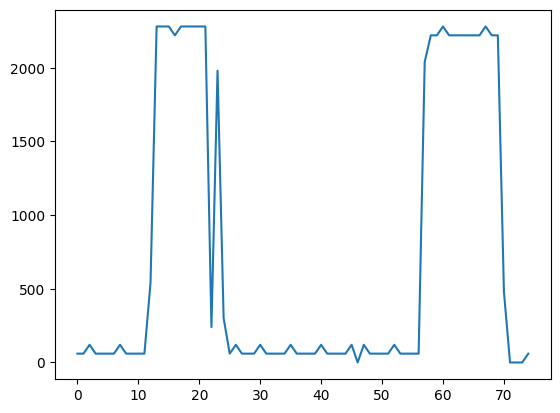

In [13]:
# show the load profile of a dishwasher
with open('process_dishwasher.json', 'r') as file_object:  #open the file in write mode
     process_dishwasher = json.load(file_object) 
total_energy = np.sum(process_dishwasher)/60
plt.plot(process_dishwasher)
print('Total energy needed by the process:', total_energy,'Wh')

In [14]:
def suitability(time_point,max_waiting_time):
    """
    Determine the suitability of a given time point for running a process with a initially empty battery.

    This function calculates the accumulated energy generation over a specified
    period, starting from the given time point and extending up to a maximum
    waiting time. If the accumulated energy generation is greater than or equal
    to a predefined total energy threshold, the function returns True, indicating
    that the time point is suitable for the process. Otherwise, it returns False.

    Parameters:
        time_point (int): The starting time point to be evaluated.
        max_waiting_time (int): The maximum duration, in time units, for which
                               energy accumulation is considered.

    Returns:
        bool: True if the accumulated energy generation is sufficient for the process,
              False if the accumulated energy generation is insufficient.

    """
    energy = 0  # start with an empty battery
    for i in range(max_waiting_time):
        if time_point+i < 8760:
            energy += power[time_point+i]
        
    if energy >= total_energy:
        return True
    return False



In [15]:
def count_starting_points(max_waiting_time):
    """
    Calculate the count of starting points suitable for a process during a period (e.g. a year).

    This function iterates through the power data array (a time series), evaluating the suitability
    of each time point using the suitability() function. If a time point is
    suitable, it increments the count of suitable starting points. The final count
    of suitable starting points is returned as the result.

    
    Parameters:
        max_waiting_time (int): The maximum tolerance to wait, in time units, for which energy accumulation is considered.

    Returns:
        int: The count of time points that are suitable for a process.
    """
    count = 0
    for i in range(len(power)):
        if suitability(i,max_waiting_time):
            count+=1
    return count

###  test different configuration:
- Max waiting time(in hours), first set it to a large number to do sanity check, and then try out different values.

- Battery capacity, set to a value larger than the total energy needed by the appliance.

- Turbine: one of the best seller backyard wind turbine, Automaxx Windmill 1500W 48V 60A, implemented at height 10m.
<img src="powercurve.png" alt="Italian Trulli" width="400" height="500">

In [17]:
## parameters to test
MAX_WAITING_TIME = 100 # int, unit:hour 
BATTERY_CAPICITY = 2000
# total_energy = 778

suitable_starting_points = np.zeros(ws10.shape[1:])
for i in range(ws10.shape[1]):
    for j in range(ws10.shape[2]):
        wind_df = pd.DataFrame(ws10[:,i,j], columns=['wind_speed'])
        column_names = pd.MultiIndex.from_arrays([['wind_speed'], ['10']], names=['variable_name', 'height'])

        wind_df.columns = column_names
        wind_df['roughness_length'] = None

        power = speed_to_power(wind_df, my_turbine=my_turbine)
        
        suitable_starting_points[i,j] = count_starting_points(max_waiting_time=MAX_WAITING_TIME)
        

In [18]:
suitable_fractions = suitable_starting_points/8760
suitable_fractions

array([[1.        , 1.        , 1.        , ..., 0.9946347 , 0.9946347 ,
        0.9946347 ],
       [1.        , 1.        , 1.        , ..., 0.99452055, 0.99452055,
        0.99452055],
       [1.        , 1.        , 1.        , ..., 0.99452055, 0.99452055,
        0.99452055],
       ...,
       [0.99942922, 0.99965753, 0.99977169, ..., 0.99931507, 0.99920091,
        0.99920091],
       [0.99954338, 0.99965753, 0.99977169, ..., 0.99931507, 0.99920091,
        0.99920091],
       [0.99977169, 0.99977169, 0.99988584, ..., 0.99920091, 0.99920091,
        0.99920091]])

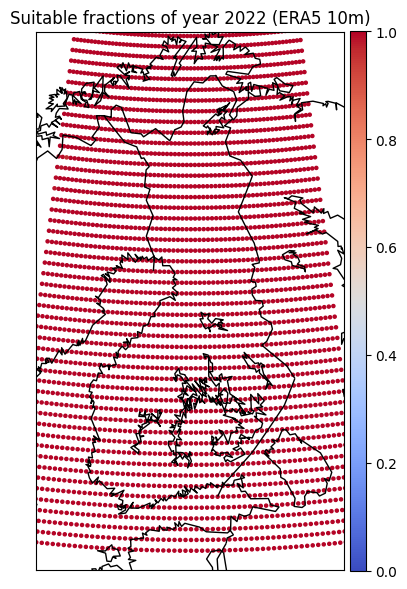

In [19]:
# visulize the results. Scatter plot with a grid-like arrangement of points is a bit strange.
fig = plt.figure(figsize=(5,7))
m = Basemap(projection='lcc',resolution='l',lat_0=64.8238, lon_0=26.2179,width=0.8E6, height=1.4E6)
x,y = m(lons,lats)
m.drawcoastlines()
# m.shadedrelief()
m.drawcountries(color='black', linewidth=1)
# m.drawstates(color='gray')
sc = plt.scatter(x, y, c=suitable_fractions,cmap=plt.cm.coolwarm, s=5, marker='o',vmin=0.000, vmax=1.000)
cb = m.colorbar()
t = plt.title(f'Suitable fractions of year 2021 (ERA5 10m)')

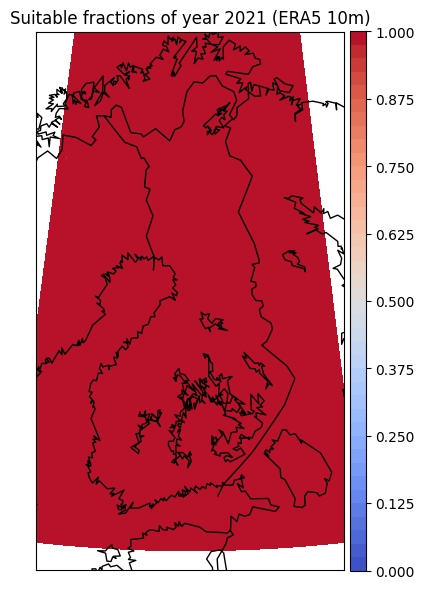

In [22]:
# visulize the results, contour plot looks better to me.
fig = plt.figure(figsize=(5,7))
m = Basemap(projection='lcc',resolution='l',lat_0=64.8238, lon_0=26.2179,width=0.8E6, height=1.4E6)
x,y = m(lons,lats)
m.drawcoastlines()
# m.shadedrelief()
m.drawcountries(color='black', linewidth=1)
# m.drawstates(color='gray')
cs = m.contourf(x,y,suitable_fractions,np.linspace(0,1,41),cmap=plt.cm.coolwarm)
cb = m.colorbar()
t = plt.title(f'Suitable fractions of year 2021 (ERA5 10m)')